## import libaries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

from numpy.random import seed

import tensorflow as tf
import keras
from keras.models import model_from_json, load_model
from keras.layers import BatchNormalization, Dropout,Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
i
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold, RepeatedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_recall_curve, auc
from keras_tuner.tuners import RandomSearch
from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.model_selection import LeaveOneGroupOut

## import data and clean

In [ ]:
#AZ data
df_AZ = pd.read_csv("../data/AZ_seq_vis.csv", delimiter = ",")


df_AZ_DL = pd.read_csv("../data/AZ_DeepSP_features.csv", delimiter = ",")
df_AZ_DL

Group Sequences into clusters

In [ ]:
df_AZ_cluster = pd.read_csv("../data/AZ_seq_clustered.csv", delimiter = ",")
df_AZ_cluster['mAb'] = 'mAb'+df_AZ_cluster['Serial number'].astype(str) #104 groups

common_mAbs = df_AZ_cluster['mAb'].isin(df_AZ_DL['Name'])
df_AZ_cluster = df_AZ_cluster[common_mAbs] #102 groups ; len(df_AZ_cluster['Clusters'].unique())
df_AZ_cluster

df_AZ_cluster.sort_values(by='Serial number', inplace=True)
#df_AZ_cluster[['mAb','Clusters']]
df_AZ_cluster

In [ ]:
df_AZ_DL_clustered = df_AZ_DL.copy()
df_AZ_DL_clustered['clusters'] = df_AZ_cluster['Clusters'].values
#df_AZ_DL_clustered.sort_values(by='Name', inplace=True)
df_AZ_DL_clustered

,Name,SAP_pos_CDRH1,SAP_pos_CDRH2,SAP_pos_CDRH3,SAP_pos_CDRL1,SAP_pos_CDRL2,SAP_pos_CDRL3,SAP_pos_CDR,SAP_pos_Hv,SAP_pos_Lv,...,SCM_pos_CDRH3,SCM_pos_CDRL1,SCM_pos_CDRL2,SCM_pos_CDRL3,SCM_pos_CDR,SCM_pos_Hv,SCM_pos_Lv,SCM_pos_Fv,Viscosity,clusters
0,mAb1,9.62,0.53,10.81,6.46,6.42,4.82,39.61,58.55,58.63,...,163.35,188.37,106.48,96.55,590.14,907.68,1210.44,2098.06,14.605886,43
1,mAb2,3.20,4.58,12.18,3.37,2.73,2.16,28.24,53.42,35.62,...,85.34,43.62,57.13,106.93,363.49,1263.48,1205.00,2460.32,6.759755,48
2,mAb3,2.82,0.17,18.35,1.83,4.83,4.97,33.65,51.03,32.06,...,36.65,62.00,32.76,35.07,328.25,1301.82,1058.81,2330.59,30.817431,22
3,mAb4,3.17,7.08,14.54,5.22,4.29,3.75,38.04,61.42,37.92,...,214.83,21.24,49.70,39.30,425.97,1426.85,1072.94,2470.29,19.007069,29
4,mAb5,2.66,3.12,10.58,2.68,4.44,6.40,30.60,52.65,38.04,...,49.23,60.50,115.52,121.89,377.13,1046.83,1377.52,2419.16,14.200295,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,mAb257,2.95,4.97,15.64,1.38,6.20,9.47,40.65,49.45,40.13,...,119.73,42.85,88.95,82.56,430.86,1219.40,1281.90,2483.95,18.418720,13
225,mAb258,2.89,3.32,14.99,1.40,6.27,9.19,38.29,46.87,39.70,...,112.46,43.43,87.61,84.73,409.46,1214.21,1270.25,2462.93,14.267126,13
226,mAb259,2.74,0.66,15.31,1.39,6.24,9.36,35.80,44.22,39.96,...,108.74,44.25,89.04,81.01,382.66,1143.07,1272.49,2395.46,29.707431,13
227,mAb260,3.23,4.85,15.26,1.29,6.22,9.24,40.40,48.80,39.55,...,123.51,43.29,86.29,84.98,513.71,1369.41,1283.40,2627.67,28.878715,13


### Import independent test set

In [ ]:
# Experimental Data
df_AZ_test= pd.read_csv('../data/DeepVis_independent_testset.csv', delimiter=',') #, header=None)
df_AZ_test

df_AZ_test_DL = pd.read_csv("../data/DeepVis_independent_testset_DeepSP_features.csv", delimiter = ",")
df_AZ_test_DL

,Name,SAP_pos_CDRH1,SAP_pos_CDRH2,SAP_pos_CDRH3,SAP_pos_CDRL1,SAP_pos_CDRL2,SAP_pos_CDRL3,SAP_pos_CDR,SAP_pos_Hv,SAP_pos_Lv,...,SCM_pos_CDRH1,SCM_pos_CDRH2,SCM_pos_CDRH3,SCM_pos_CDRL1,SCM_pos_CDRL2,SCM_pos_CDRL3,SCM_pos_CDR,SCM_pos_Hv,SCM_pos_Lv,SCM_pos_Fv
0,SF_1,2.13,2.52,14.45,1.90,3.59,3.17,27.50,58.42,30.52,...,3.18,19.58,29.51,116.77,41.76,55.55,263.84,907.11,1219.44,2109.09
1,SF_2,1.84,4.34,8.94,1.61,10.42,9.95,38.41,58.49,44.57,...,27.89,22.46,154.70,23.50,37.77,90.65,360.76,1224.56,1132.76,2335.69
2,SF_4,2.81,1.75,20.81,0.62,3.46,5.03,34.88,63.38,44.27,...,71.40,29.85,41.84,37.09,39.44,22.18,246.88,1165.60,830.06,1963.78
3,SF_5,3.14,0.30,26.26,1.86,0.19,6.30,38.34,73.47,38.45,...,27.55,11.26,56.28,13.80,66.96,50.26,225.27,993.92,1097.46,2073.50
4,SF_6,2.49,0.11,15.97,2.55,0.56,1.85,23.77,61.60,33.18,...,42.21,10.15,77.49,142.88,81.87,61.18,415.96,1010.63,1221.23,2209.07
5,SF_10,9.65,2.27,23.06,6.46,0.99,8.05,49.35,61.49,48.58,...,45.50,18.14,136.59,18.76,71.84,66.39,359.89,1329.42,1113.38,2426.39
6,SF_11,8.22,2.84,11.41,4.32,2.67,5.91,36.58,50.78,44.49,...,52.31,74.92,82.05,72.28,45.88,88.02,428.92,1007.11,848.10,1808.07
7,SF_17,4.42,2.10,16.02,2.52,7.36,1.80,34.05,60.68,34.21,...,51.69,-3.80,91.03,14.38,23.04,32.92,198.84,1157.94,944.08,2085.39
8,SF_19,1.43,3.45,5.46,2.13,2.77,8.27,23.20,45.44,37.32,...,15.41,8.22,46.54,8.15,17.47,35.44,130.62,1107.60,954.66,2039.48
9,SF_21,2.34,0.20,10.53,4.14,6.53,15.28,40.84,55.97,49.08,...,25.99,14.52,26.37,19.89,69.96,26.28,174.26,1044.72,1139.79,2159.29


In [ ]:
df_Apgar = pd.read_csv('../data/Apgar_DeepSP_descriptors.csv')
df_Apgar #38 independent test set

ANN model - building and tuning

In [ ]:
# Define the model creation and training function
optimizer = Adam(0.0001)
def create_and_train_model(X_train,X_val, y_train, y_val, sampleweight_train, sampleweight_val, filename):
    act='tanh'
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(X_train.shape[1],)))
    model.add(keras.layers.Dense(units=128, activation = act , name="Dense_1")) #model.add(Dropout(0.5))
    model.add(keras.layers.Dense(units=64, activation = act, name="Dense_2"))
    model.add(keras.layers.Dense(units=32, activation = act, name="Dense_3"))
    model.add(keras.layers.Dense(units=16, activation = act, name="Dense_4"))

    model.add(keras.layers.Dense(1, activation='sigmoid', name="Dense_5"))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Define callbacks for model checkpointing
    filepath = 'ANN_models/' + filename + '.h5'
    checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', verbose=0, 
                                 save_best_only=True, save_weights_only=True, mode='max')
    callbacks = [checkpoint]
    
    # Train the model
    model.fit(x=X_train, y=y_train, sample_weight=sampleweight_train, validation_data=(X_val, y_val), epochs=50, 
                        callbacks=callbacks, batch_size=32, verbose=0)

    
    # Save the model architecture to JSON
    with open('ANN_models/' + filename + '.json', "w") as json_file:
        json_file.write(model.to_json())
        
    # Load the saved model and return it for evaluation
    with open('ANN_models/' + filename + '.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        
    #load model
    pred_model = model_from_json(loaded_model_json)
    pred_model.load_weights(filepath)
    pred_model.compile(optimizer=optimizer, metrics=['accuracy'], weighted_metrics=['accuracy'])
    train_acc = pred_model.evaluate(X_train, y_train, sample_weight=sampleweight_train, verbose=0)[1]
    val_acc = pred_model.evaluate(X_val, y_val, sample_weight=sampleweight_val, verbose=0)[1]
    
    return pred_model, train_acc, val_acc

def make_predictions(models, set, X, y):
    predictions = []
    for model in models:
        # Make predictions on the new data
        pred = model.predict(X, verbose=0)
        predictions.append(pred)

    # Combine the predictions using majority voting
    final_pred = np.where(np.array(predictions).mean(axis=0) >= 0.5, 1, 0)
    final_accuracy = accuracy_score(y, final_pred)

    
    # Display the final prediction list
    print("Final "+set+" Predictions based on Majority:")
    print(final_pred.tolist())
    print("Accuracy of majority predictions is ", final_accuracy)     

X = df_AZ_DL_clustered.iloc[:, 1:-2].values
y = np.where(df_AZ_DL_clustered['Viscosity'] < 20, 0, 1)
groups = df_AZ_DL_clustered['clusters'].values
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

import joblib
joblib.dump(sc, "../data/DeepViscosity_scaler.save")

df_AZ_test['Viscosity'] = np.where(df_AZ_test['Exp_Viscosity'] < 20, 0, 1)
X_test = np.array(df_AZ_test_DL.iloc[:, 1:])
y_test = np.array(df_AZ_test['Viscosity'])
X_test_scaled = sc.transform(X_test) 

df_Apgar = pd.read_csv('../data/Apgar_DeepSP_descriptors.csv')
X_apgar = df_Apgar.iloc[:, 1:]
X_scaled_apgar = sc.transform(X_apgar)
y_apgar = np.where(pd.read_csv('../data/AZ_Apgar_others.csv')['Exp_Viscosity'] < 20, 0, 1).tolist()

logo = LeaveOneGroupOut()
unique_groups, group_counts = np.unique(groups, return_counts=True)
group_count_dict = dict(zip(unique_groups, group_counts))
sample_weight = np.array([1.0 / group_count_dict[group] for group in groups])

X has feature names, but StandardScaler was fitted without feature names


Training

In [18]:
models = []
train_accs = []
val_accs = []
val_mAbs = []
splits = []
for i, (train_index, test_index) in enumerate(logo.split(X_scaled, y, groups)):
    X_train, X_val = X_scaled[train_index], X_scaled[test_index]
    y_train, y_val = y[train_index], y[test_index]
    val_mAb = df_AZ_DL_clustered.Name[test_index]

    sample_weight_train = sample_weight[train_index]
    sample_weight_val = sample_weight[test_index]
    splits.append([len(X_train), len(X_val)])
    
    # Create and train the model
    file = 'ANN_logo_' + str(i)
    model, train_acc, val_acc = create_and_train_model(X_train, X_val, y_train, y_val, sample_weight_train, sample_weight_val, file)
    
    models.append(model)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_mAbs.append(val_mAb)

Prediction

In [ ]:
print('Splits: ', splits)
print('------------------------------------------------------------')
print('Training accuracies for all splits are :')
print(train_accs)
print('Average training accuracy is ', np.mean(train_accs))
print('------------------------------------------------------------')
print('Validation accuracies for all splits are :')
print(val_accs)
print('Average validation accuracy is ', np.mean(val_accs))
print('------------------------------------------------------------')
make_predictions(models, 'AZ_mAb_229', X_scaled, y)
print('------------------------------------------------------------')
make_predictions(models, 'Lai_mAb_16 test', X_test_scaled, y_test)
print('------------------------------------------------------------')
make_predictions(models,'Apgar_mAb_38', X_scaled_apgar, y_apgar)

In [ ]:
data = {"splits": splits, "train_accs":train_accs, "val_accs": val_accs, "val_mAbs":[list(series) for series in val_mAbs]}

df1 = pd.DataFrame(data)
df1.to_csv('../data/splits_accuracy.csv')
df1

,splits,train_accs,val_accs,val_mAbs
0,"[225, 4]",0.511111,0.000000,"[mAb98, mAb99, mAb100, mAb101]"
1,"[228, 1]",0.811404,1.000000,[mAb97]
2,"[228, 1]",0.719298,1.000000,[mAb229]
3,"[212, 17]",0.683962,0.647059,"[mAb105, mAb106, mAb108, mAb110, mAb111, mAb11..."
4,"[228, 1]",0.635965,1.000000,[mAb128]
...,...,...,...,...
97,"[228, 1]",0.736842,1.000000,[mAb27]
98,"[228, 1]",0.706140,1.000000,[mAb9]
99,"[228, 1]",0.697368,1.000000,[mAb238]
100,"[228, 1]",0.649123,1.000000,[mAb25]


In [21]:
import shap
shap.initjs()
feature_names = df_AZ_DL.columns.to_list()[1:-1]

def gen_shap_values(model, X, background_data):
    explainer = shap.DeepExplainer(model, background_data)
    shap_values = explainer.shap_values(X)
    return explainer, shap_values
len(feature_names)

30

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


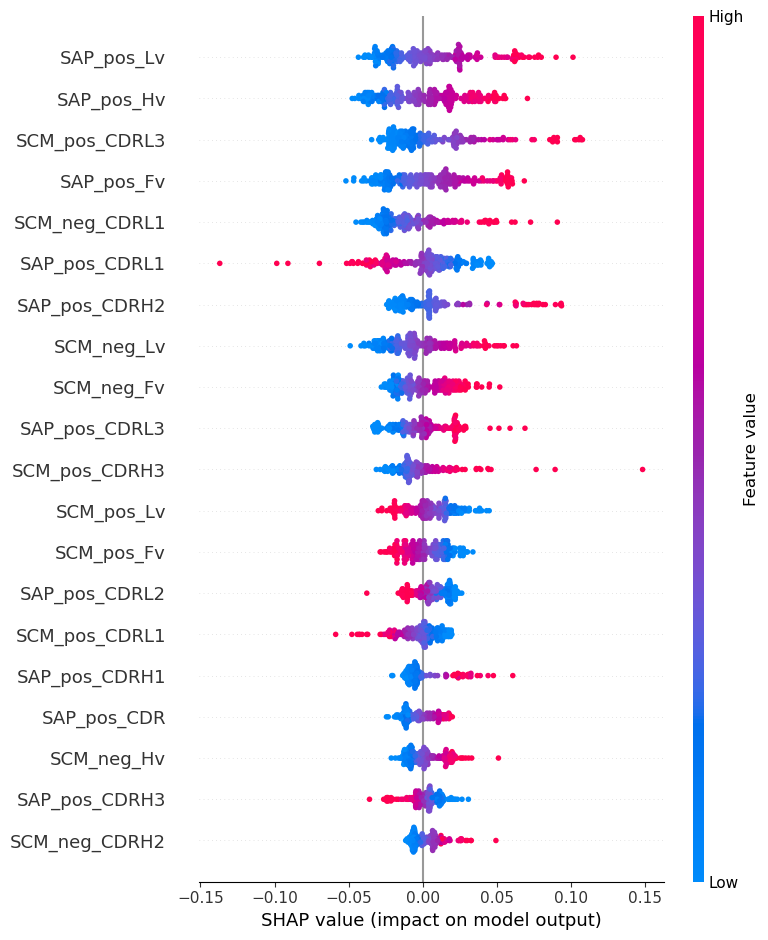

In [22]:
shapvalue_list = []
for model in models:
    explainer, shap_values = gen_shap_values(model, X_scaled, X_test_scaled)
    shapvalue_list.append(shap_values[0])
    
shap.summary_plot(np.mean(shapvalue_list, axis = 0), X_scaled, feature_names=feature_names)